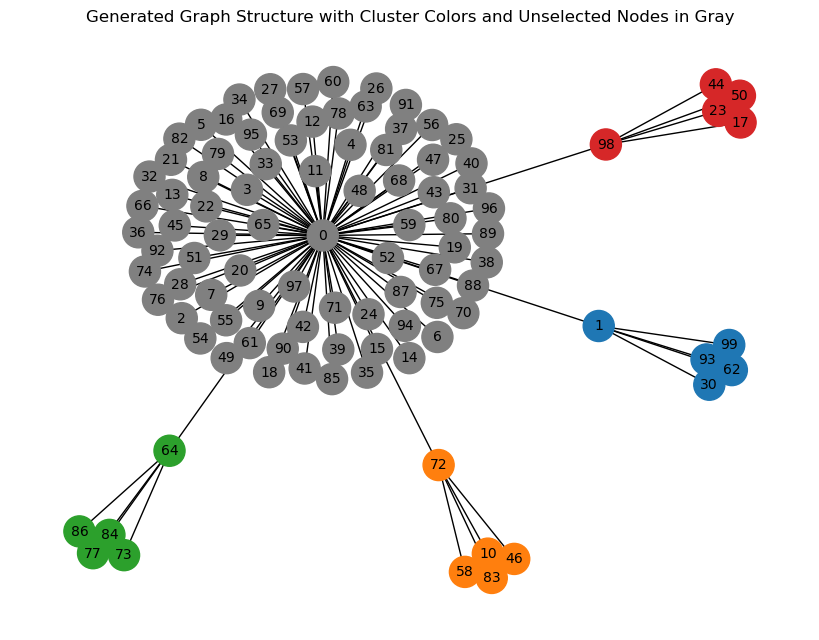

Clusters: [array([30, 93, 62, 99,  1]), array([46, 58, 10, 72, 83]), array([86, 77, 64, 73, 84]), array([17, 98, 23, 44, 50])]
Selected Features: [30 93 62 99  1 46 58 10 72 83 86 77 64 73 84 17 98 23 44 50]


In [1]:
import numpy as np
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define colors for each cluster, and use gray for unselected nodes
def visualize_graph(G, clusters, selected_features):
    # Get distinct colors for clusters using matplotlib's Tableau colors
    unique_colors = list(mcolors.TABLEAU_COLORS.values())
    colors = unique_colors[:len(clusters)]  # Select enough colors for each cluster
    unselected_color = "gray"  # Color for nodes not in any cluster

    # Create a color mapping for each node
    node_colors = []
    for node in range(G.number_of_nodes()):
        if node in selected_features:
            # Find which cluster the node belongs to
            for i, cluster in enumerate(clusters):
                if node in cluster:
                    node_colors.append(colors[i % len(colors)])
                    break
        else:
            # If the node is not selected, color it gray
            node_colors.append(unselected_color)

    # Draw the graph with cluster-based colors and gray for unselected nodes
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)  # Fixed layout for consistent visualization
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=10)
    plt.title("Generated Graph Structure with Cluster Colors and Unselected Nodes in Gray")
    plt.show()


def generate_synthetic_data_with_graph(n, d, k, h, theta, gamma, visualize=False):
    # Step 1: Generate the design matrix X with i.i.d. N(0, 1) entries
    X = np.random.normal(0, 1, (n, d))
    
    # Step 2: Randomly select k features as non-zero/contributing features
    selected_features = np.random.choice(d, k, replace=False)
    
    # Step 3: Divide the selected features into h clusters
    cluster_size = k // h  # Assume k is divisible by h for simplicity TODO: imbalanced clusters
    clusters = [selected_features[i * cluster_size : (i + 1) * cluster_size] for i in range(h)]
    
    # Step 4: Construct the regression weight vector w
    w = np.zeros(d)
    for cluster in clusters:
        sign = np.random.choice([-1, 1])  # Assign same sign to all features in the cluster
        for feature in cluster:
            w[feature] = sign * (1 / np.sqrt(k))
    
    # Step 5: Create a sparse adjacency matrix for the graph
    adj_matrix = sp.lil_matrix((d, d))  # Start with a sparse matrix in List of Lists format
    
    for i in range(d):
        for j in range(i + 1, d):
            # Check if i and j are in the same cluster
            same_cluster = any(i in cluster and j in cluster for cluster in clusters)
            prob = theta if same_cluster else (1 - theta)
            
            if np.random.rand() < prob:
                adj_matrix[i, j] = 1
                adj_matrix[j, i] = 1  # Ensure symmetry
    
    # Ensure the graph is connected
    G = nx.from_scipy_sparse_array(adj_matrix)  
    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        for i in range(1, len(components)):
            # Connect an isolated component to the main component
            G.add_edge(next(iter(components[i])), next(iter(components[0])))
    
    # Update the adjacency matrix after connecting components
    adj_matrix = nx.to_scipy_sparse_array(G, format="csr")
    
    # Step 6: Compute the Laplacian matrix as a sparse matrix
    degree_matrix = sp.diags(np.ravel(adj_matrix.sum(axis=1)))
    laplacian_matrix = degree_matrix - adj_matrix
    
    # Step 7: Generate the response vector y = Xw + epsilon
    epsilon = np.random.normal(0, gamma, n)
    y = X @ w + epsilon

    # Optional: Visualize the graph with cluster-based colors
    if visualize:
        visualize_graph(G, clusters, selected_features=selected_features)
    
    # # Optional: Visualize the graph
    # plt.figure(figsize=(8, 6))
    # nx.draw(G, with_labels=True, node_color="skyblue", node_size=500, font_size=10)
    # plt.title("Generated Graph Structure")
    # plt.show()
    
    return X, w, y, adj_matrix, laplacian_matrix, clusters, selected_features

# Parameters
n = 100  # Number of samples
d = 100   # Number of features
k = 20   # Number of non-zero features
h = 4    # Number of clusters
theta = 1  # Probability of connection within clusters
gamma = 0.1  # Noise standard deviation

# Generate synthetic data
X, w, y, adj_matrix, laplacian_matrix, clusters, selected_features = generate_synthetic_data_with_graph(n, d, k, h, theta, gamma, visualize=True)

# Print outputs for inspection
# print("Design Matrix X:", X)
# print("Weight Vector w:", w)
# print("Response Vector y:", y)
# print("Adjacency Matrix (Sparse):\n", adj_matrix.toarray())
# print("Laplacian Matrix (Sparse):\n", laplacian_matrix.toarray())
print("Clusters:", clusters)
print("Selected Features:", selected_features)


In [2]:
from gurobipy import Model, GRB, QuadExpr
def ProjOperator_Gurobi(m, k, d, h):
    """
    This function we return a projection operator that projects the input vector m onto the simplex
    Parameters:
    - m: input vector (maybe in it matrix form -- no)
    - k: sparsity level
    - d: number of features
    - h: number of pre-defined clusters, which can be read from the input vector m (omit for now, since we pass the vector form, so we cannot know d and h directly)
    """

    # Create constraint matrix A for the sparsity level
    A = np.ones((1, d*h))
    b = np.array([k])

    # Create constraint matrix B for each feature belongs to at most one cluster
    # Initialize B as an empty matrix with shape (0, d*h)
    B = np.empty((0, d*h))

    # Initialize c as an empty array
    c = np.empty((0, 1))

    for i in range(d):
        # Create a new row of zeros with shape (1, d*h)
        B_row = np.zeros(d*h)
        # Set a specific element in the row to 1
        B_row[i*h: (i+1)*h] = 1

        # Stack the new row onto B
        B = np.vstack([B, B_row]) 

        # Append 1 to vector c
        c = np.vstack([c, [[1]]])

    # Concatenate A and B to create the constraint matrix
    C = np.vstack([A, B])
    Cb = np.vstack([b, c])

    # Create a Gurobi model
    model = Model()

    # Add variables
    x = model.addMVar(d*h, lb=0.0, ub=1.0)

    # Set objective function
    Q = np.eye(d*h)
    f = -2*m.flatten()
    x = model.addMVar(d*h, ub=1.0, lb=0.0)
    model.setObjective(x@Q@x + x@f)
    model.addConstr(C @ x <= Cb)

    # Set Gurobi parameters
    model.setParam('OutputFlag', 0)
    model.setParam('IterationLimit', 500)

    # Optimize model
    model.optimize()

    # Get the results
    x = x.x

    return x[:, np.newaxis]


In [ ]:
# Parameters
n = 100  # Number of samples
d = 100   # Number of features
k = 20   # Number of non-zero features
h = 4    # Number of clusters
theta = 1  # Probability of connection within clusters
gamma = 0.1  # Noise standard deviation

# Generate synthetic data
X, w, y, adj_matrix, laplacian_matrix = generate_synthetic_data_with_graph(n, d, k, h, theta, gamma)


In [7]:
import numpy as np
import scipy.io as sio
from scipy.linalg import toeplitz
from scipy.stats import multivariate_normal
import time

from L0Obj import L0Obj
from ProjCSimplex import ProjCSimplex
from minConf.minConf_PQN import minConF_PQN
import random


tStart = time.process_time()
# Generate synthetic data
# Parameters
n = 100  # Number of samples
d = 100   # Number of features
k = 20   # Number of non-zero features
h = 4    # Number of clusters
nVars = d*h # Number of Boolean variables in m
theta = 1  # Probability of connection within clusters
gamma = 0.1  # Noise standard deviation
pho = 0.2
mu = 0.2
SNR = 1

# Generate synthetic data
X, w_true, y, adj_matrix, L, clusters, selected_features = generate_synthetic_data_with_graph(n, d, k, h, theta, gamma)

# we need to modify the matrix X to define the objective function
X_hat = np.repeat(X, h, axis=1)


print("Check!!!")
tEnd = time.process_time() - tStart
print("Execution time (generating the data):", tEnd)

# Initial guess of parameters
m_initial = np.ones((nVars, 1)) * (1 / nVars)


# Set up Objective Function L0Obj(X, m, y, pho, mu):
funObj = lambda m: L0Obj(X_hat, m, y, L, pho, mu, d, h)

# Set up Simplex Projection Function
funProj = lambda m: ProjOperator_Gurobi(m, k, d, h)

tEnd = time.process_time() - tStart
print("Execution time(Before):", tEnd)
print("start!!!")
# Solve with PQN
options = {'maxIter': 50}
tStart = time.process_time()
uout, obj, _ = minConF_PQN(funObj, m_initial, funProj, options)
print(f"uout: {uout}")
tEnd = time.process_time() - tStart

B = np.sort(-uout.flatten())
Ranktmp = np.argsort(-uout.flatten())
Rank = np.sort(Ranktmp[:k])
# uout[Ranktmp[:k[0][0]]]

Indtrue = np.where(utrue)
# print(Rank)
# print("IndTrue", Indtrue)
# print(f"Indtrue: {Indtrue}, Rank: {Rank}")
C = np.intersect1d(Rank, Indtrue)
# Convert numpy arrays to tuples, if necessary
# Rank_tuple = [tuple(r) for r in Rank]
# Indtrue_tuple = [tuple(i) for i in Indtrue]

# Find the intersection
AccPQN = len(C) / k

print("Execution time:", tEnd)
print("Accuracy PQN:", AccPQN)


Check!!!
Execution time (generating the data): 0.0587219999999995
Execution time(Before): 0.06173899999999932
start!!!
 Iteration   FunEvals Projections     Step Length    Function Val        Opt Cond


ValueError: operands could not be broadcast together with shapes (400,) (100,4) 

In [26]:
import numpy as np

# Example matrix X
X = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])

# Number of repetitions per column
h = 2

# Repeat each column h times
X_repeated = np.repeat(X, h, axis=1)

print("Original Matrix X:")
print(X)

print("\nNew Matrix with Columns Repeated:")
print(X_repeated)


Original Matrix X:
[[1 2 3]
 [4 5 6]
 [7 8 9]]

New Matrix with Columns Repeated:
[[1 1 2 2 3 3]
 [4 4 5 5 6 6]
 [7 7 8 8 9 9]]


In [11]:
import numpy as np
# read the data
data = np.load('synthetic_data.npz', allow_pickle=True)
print(data)

NpzFile 'synthetic_data.npz' with keys: X, w, y, adj_matrix, laplacian_matrix...


In [13]:
print(data['adj_matrix'])

  (0, 1)	1.0
  (0, 2)	1.0
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 5)	1.0
  (0, 6)	1.0
  (0, 7)	1.0
  (0, 8)	1.0
  (0, 9)	1.0
  (0, 10)	1.0
  (0, 11)	1.0
  (0, 12)	1.0
  (0, 13)	1.0
  (0, 14)	1.0
  (0, 16)	1.0
  (0, 17)	1.0
  (0, 18)	1.0
  (0, 19)	1.0
  (0, 20)	1.0
  (0, 21)	1.0
  (0, 22)	1.0
  (0, 23)	1.0
  (0, 24)	1.0
  (0, 25)	1.0
  (0, 26)	1.0
  :	:
  (181, 0)	1.0
  (182, 0)	1.0
  (183, 0)	1.0
  (184, 0)	1.0
  (185, 0)	1.0
  (186, 44)	1.0
  (186, 92)	1.0
  (186, 131)	1.0
  (186, 149)	1.0
  (187, 58)	1.0
  (187, 82)	1.0
  (187, 83)	1.0
  (187, 114)	1.0
  (188, 0)	1.0
  (189, 0)	1.0
  (190, 0)	1.0
  (191, 0)	1.0
  (192, 0)	1.0
  (193, 0)	1.0
  (194, 0)	1.0
  (195, 0)	1.0
  (196, 0)	1.0
  (197, 0)	1.0
  (198, 0)	1.0
  (199, 0)	1.0


In [14]:
dense_array = adj_matrix.toarray()  # Converts sparse matrix to dense

print(dense_array)

[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [15]:
# i want to check if the graph represented by the adjacency matrix is connected
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph from the adjacency matrix
G = nx.from_numpy_array(dense_array)

# Check if the graph is connected
is_connected = nx.is_connected(G)
print("Is the graph connected?", is_connected)

Is the graph connected? True


In [2]:
import numpy as np
import scipy.io as sio
from scipy.linalg import toeplitz
from scipy.stats import multivariate_normal
import time

from L0Obj import L0Obj
from data_generator import generate_synthetic_data_with_graph, read_synthetic_data_from_file, save_synthetic_data_to_file
from ProjectOperator import ProjOperator_Gurobi
from minConf.minConf_PQN import minConF_PQN
import random


tStart = time.process_time()
# Generate synthetic data
# Parametersx
n = 500  # Number of samples
d = 300   # Number of features
k = 10   # Number of non-zero features
h = 2    # Number of clusters
nVars = d*h # Number of Boolean variables in m
theta = 1  # Probability of connection within clusters
gamma = 1.5  # Noise standard deviation
pho = np.sqrt(n)
mu = np.sqrt(n/2)
SNR = 1

fixed_seed = 1
# read a fixed synthetic data from a file if fixed_seed is True because we want to compare the results with the original results
if fixed_seed:
    file_path = "synthetic_data.npz"
    X, w_true, y, adj_matrix, L, clusters_true, selected_features_true = read_synthetic_data_from_file(file_path)
else:
    # Generate synthetic data
    X, w_true, y, adj_matrix, L, clusters_true, selected_features_true = generate_synthetic_data_with_graph(n, d, k, h, theta, gamma, visualize=True)
    # Save the synthetic data to a file
    file_path = "synthetic_data.npz"
    save_synthetic_data_to_file(file_path, X, w_true, y, adj_matrix, L, clusters_true, selected_features_true)

print("selected_features_true", selected_features_true)
print("clusters_true", clusters_true)

# we need to modify the matrix X to define the objective function
X_hat = np.repeat(X, h, axis=1)
# print("w_true:", w_true) 

print("Check!!!")
tEnd = time.process_time() - tStart
print("Execution time (generating the data):", tEnd)

# Initial guess of parameters
m_initial = np.ones((nVars, 1)) * (1 / nVars)


# Set up Objective Function L0Obj(X, m, y, L, pho, mu, d, h)::
funObj = lambda m: L0Obj(X_hat, m, y, L, pho, mu, d, h)

# Set up Simplex Projection Function ProjOperator_Gurobi(m, k, d, h):
funProj = lambda m: ProjOperator_Gurobi(m, k, d, h)

reading the synthetic data from the file synthetic_data.npz
(1000, 300) (300,) (1000,) (300, 300) (300, 300) (5, 4) (20,)
selected_features_true [ 27  35 182 204   7  29  72  96 233 212 142 203 150 297  76 137  70 114
 174 268]
clusters_true [[ 27  35 182 204]
 [  7  29  72  96]
 [233 212 142 203]
 [150 297  76 137]
 [ 70 114 174 268]]
Check!!!
Execution time (generating the data): 0.003198999999999952


In [3]:
import scipy.sparse as sp
def read_synthetic_data_from_file(file_path):
    print("reading the synthetic data from the file", file_path)
    with np.load(file_path, allow_pickle=True) as data:
        X = data["X"]
        w = data["w"]
        y = data["y"]
        clusters = data["clusters"]
        selected_features = data["selected_features"]
    adj_matrix = sp.load_npz(file_path.replace(".npz", "_adj_matrix.npz"))
    laplacian_matrix = sp.load_npz(file_path.replace(".npz", "_laplacian_matrix.npz"))
    print(X.shape, w.shape, y.shape, adj_matrix.shape, laplacian_matrix.shape, clusters.shape, selected_features.shape)
    return X, w, y, adj_matrix, laplacian_matrix, clusters, selected_features

data = read_synthetic_data_from_file("synthetic_data.npz")

print(data[1])

reading the synthetic data from the file synthetic_data.npz
(1000, 300) (300,) (1000,) (300, 300) (300, 300) (5, 4) (20,)
[ 0.          0.          0.          0.          0.          0.
  0.         -0.77841166  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -1.54262619  0.         -0.77841166
  0.          0.          0.          0.          0.         -1.54262619
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.27552618  0.
 -0.77841166  0.          0.          0.         -0.7201089   0.
  0.          0. 

In [4]:
# read from the .mat file
mout = sio.loadmat('mout.mat')['mout']
print("clusters_true", clusters_true)  
print("selected_features_true", selected_features_true)
# round the result randomly according to its value for a few times and select the best one in terms of the objective function
def test(T):
    min_obj = np.inf
    min_round = np.zeros((nVars, ))  # initialize the best result
    m_grouped = mout.reshape(d, h)
    """
    here we propose a different way to round this result. note that we have introduce h times more variables than the original problem. so the number are diluted, it is hard to get more than a lot of ones in the result if we round it according to its probability. because even the selected one are very small.

    so we need to, first, treat variables associated with the same feature as a whole, take the sum, and then round it according to the probability to determine whether this feature is selected or not. Then, for the selected features, we need to determine which cluster it belongs to according to the probability.
    """
    for _ in range(T):
        one_realization = np.zeros((d, h))
        feature_round = (np.random.rand(d)<np.sum(m_grouped, axis=1)).astype(int)

        for i in range(d):
            if feature_round[i] == 1:
                cluster = np.random.choice(h, p=m_grouped[i]/np.sum(m_grouped[i])) # TODO: another choice is to introduce a temperature parameter to control the randomness or an extra "discard" choice with the 1- sum(m_grouped[i]) probability
                one_realization[i, cluster] = 1

        m_round = one_realization.flatten()
        obj = funObj(m_round)[0]
        if obj < min_obj:
            min_obj = obj
            min_round = m_round

    tEnd = time.process_time() - tStart

    # print("min_obj", min_obj)
    # print("min_round", min_round)

    selected_features_predict = []
    clusters_predict = {}
    # parse the result m_round to the selected features and clusters
    m = min_round.reshape(d, h)
    for i in range(d):
        if np.sum(m[i]) > 0:
            selected_features_predict.append(i)
            cluster = np.where(m[i] > 0)[0][0]
            if cluster in clusters_predict:
                clusters_predict[cluster].append(i)
            else:
                clusters_predict[cluster] = [i]

    # find the intersection of the selected features and clusters
    C = np.intersect1d(selected_features_true, selected_features_predict)

    # Find the intersection
    AccPQN = len(C) / k

    print("Accuracy PQN:", AccPQN)
    print("clusters_predict", clusters_predict)

    print("selected_features_predict", selected_features_predict)
    return AccPQN


clusters_true [[ 27  35 182 204]
 [  7  29  72  96]
 [233 212 142 203]
 [150 297  76 137]
 [ 70 114 174 268]]
selected_features_true [ 27  35 182 204   7  29  72  96 233 212 142 203 150 297  76 137  70 114
 174 268]


In [5]:
T = [1, 10, 100, 500, 1000]
res = []
for t in T:
    acc = test(t)
    res.append(acc)


Accuracy PQN: 0.1
clusters_predict {1: [112]}
selected_features_predict [112]
Accuracy PQN: 0.1
clusters_predict {0: [266], 1: [270]}
selected_features_predict [266, 270]
Accuracy PQN: 0.2
clusters_predict {1: [77, 266], 0: [294]}
selected_features_predict [77, 266, 294]
Accuracy PQN: 0.3
clusters_predict {1: [77, 90, 210]}
selected_features_predict [77, 90, 210]
Accuracy PQN: 0.3
clusters_predict {1: [29, 90, 210, 270], 0: [281]}
selected_features_predict [29, 90, 210, 270, 281]


In [6]:
T = [5000 , 6000, 10000]
res = []
for t in T:
    acc = test(t)
    res.append(acc)


Accuracy PQN: 0.5
clusters_predict {0: [77, 90, 210], 1: [112, 270]}
selected_features_predict [77, 90, 112, 210, 270]
Accuracy PQN: 0.3
clusters_predict {1: [77, 90, 210]}
selected_features_predict [77, 90, 210]
Accuracy PQN: 0.3
clusters_predict {0: [77, 90, 210]}
selected_features_predict [77, 90, 210]


In [18]:
# we use rank instead of random rounding
mout = sio.loadmat('mout.mat')['mout']
m_grouped = mout.reshape(300, 5)

feature_prob = np.sum(m_grouped, axis=1)
feature_rank = np.argsort(np.abs(feature_prob))[::-1]

print("feature_rank", feature_rank[:25])

feature_rank [251 207 137 105 180 155 234 272 119  21 125  41 206  84 209 100  34 182
 253 177  95 256 143 133 186]


In [38]:
selected_features_true = [268, 25, 223, 86, 78, 210, 232, 205, 266, 264, 279, 73, 204, 194, 293, 176, 55, 297, 15, 140]
intersect = np.intersect1d(selected_features_true, feature_rank[:20])
print("intersect", len(intersect)/20)
print("wrong", [x for x in feature_rank[:20] if x not in selected_features_true])
print("missed", [x for x in selected_features_true if x not in feature_rank[:20]])

intersect 0.95
wrong [111]
missed [293]


In [83]:
import numpy as np
import scipy.io as sio
mout = sio.loadmat('mout.mat')['mout']
m = mout.reshape(500,5)

print(m[:100])

[[3.26767921e-06 3.26767921e-06 3.26767921e-06 3.26767921e-06
  3.26767921e-06]
 [4.55667808e-06 4.55667808e-06 4.55667808e-06 4.55667808e-06
  4.55667808e-06]
 [3.48334278e-06 3.48334278e-06 3.48334278e-06 3.48334278e-06
  3.48334278e-06]
 [2.81611915e-06 2.81611915e-06 2.81611915e-06 2.81611915e-06
  2.81611915e-06]
 [7.00972337e-06 7.00972337e-06 7.00972337e-06 7.00972337e-06
  7.00972337e-06]
 [7.26030353e-06 7.26030353e-06 7.26030353e-06 7.26030353e-06
  7.26030353e-06]
 [3.14076465e-06 3.14076465e-06 3.14076465e-06 3.14076465e-06
  3.14076465e-06]
 [1.49448563e-06 1.49448563e-06 1.49448563e-06 1.49448563e-06
  1.49448563e-06]
 [1.11078132e-05 1.11078132e-05 1.11078132e-05 1.11078132e-05
  1.11078132e-05]
 [3.47404999e-06 3.47404999e-06 3.47404999e-06 3.47404999e-06
  3.47404999e-06]
 [7.42992618e-06 7.42992618e-06 7.42992618e-06 7.42992618e-06
  7.42992618e-06]
 [3.47907407e-06 3.47907407e-06 3.47907407e-06 3.47907407e-06
  3.47907407e-06]
 [7.98315662e-06 7.98315662e-06 7.983156

In [10]:
mx = np.array([[1, 2, 3],[4, 5, 6],[7, 8, 9]])
mxx= mx.flatten()
print(mx, mx.shape)
print(mxx, mxx.shape)
m_hat = np.repeat(mx, 5, axis=1)
print(m_hat, m_hat.shape)

[[1 2 3]
 [4 5 6]
 [7 8 9]] (3, 3)
[1 2 3 4 5 6 7 8 9] (9,)
[[1 1 1 1 1 2 2 2 2 2 3 3 3 3 3]
 [4 4 4 4 4 5 5 5 5 5 6 6 6 6 6]
 [7 7 7 7 7 8 8 8 8 8 9 9 9 9 9]] (3, 15)


In [21]:
import pickle
import scipy.sparse as sp
n = 1000  # Number of samples
d = 500   # Number of features
# k = 20  # Number of non-zero features
h_total = 5    # number of cluster in the graph
h = 5 # number of cluster that are selected i.e. related to the dependent variable
nVars = d*h # Number of Boolean variables in m
inter_cluster = 1 # probability of inter-cluster edges in graph
outer_cluster = 0 # probability of outer-cluster edges in graph
gamma = 1.5  # Noise standard deviation
visualize = 0
mu = 1

def read_synthetic_data(file_path, visualize=False):
    """
    Load synthetic data saved with pickle.
    
    Parameters:
    - file_path: Path to load the data from.
    
    Returns:
    - X, w, y, adj_matrix, laplacian_matrix, clusters, k.
    """
    print(f"Reading synthetic data from file: {file_path}")
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    # Debug output for loaded data
    print(f"Loaded data:")
    print(f"  X shape: {data['X'].shape}")
    print(f"  w shape: {data['w'].shape}")
    print(f"  y shape: {data['y'].shape}")
    print(f"  adj_matrix shape: {data['adj_matrix'].shape}")
    print(f"  laplacian_matrix shape: {data['laplacian_matrix'].shape}")
    print(f"  clusters length: {len(data['clusters'])}")
    print(f"  k: {data['k']}")

    if visualize:
        visualize_graph(data['adj_matrix'])
    
    return (data['X'], data['w'], data['y'], 
            data['adj_matrix'], data['laplacian_matrix'], 
            data['clusters'], data['k'])

file_path = "data/synthetic_data.mat"
print("Fixed seed is enabled. Reading synthetic data from file.")
# Read synthetic data from the saved files
X, w_true, y, adj_matrix, L, clusters_true, k = read_synthetic_data(file_path, visualize=visualize)

m_ground_truth = np.zeros((d, h))
for c, cluster in enumerate(clusters_true[:h]):
    for i in cluster:
        m_ground_truth[i, c] = 1
print(f"m_ground_truth: {m_ground_truth}")
pho = d * 4 * k
epsilon = 0.1
r = 1 + epsilon

eta = 2 * r * mu + 2 * d + 0.4 * (pho ** 2) 
L = sp.csr_matrix(L + r * np.eye(d)) # this can keep L as np.ndarray instead of np.matrix which will mess up with the flatten() function


M = m_ground_truth # generate the assignment matrix
graph_penalty = 0.5 * mu * np.trace(M.T @ L @ M) # generate the graph penalty term

Fixed seed is enabled. Reading synthetic data from file.
Reading synthetic data from file: data/synthetic_data.mat
Loaded data:
  X shape: (1000, 500)
  w shape: (500,)
  y shape: (1000,)
  adj_matrix shape: (500, 500)
  laplacian_matrix shape: (500, 500)
  clusters length: 5
  k: 499
m_ground_truth: [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [24]:
import pickle
from scipy.io import savemat

# Load pickle file
with open('/Users/aolongli/Desktop/Research-GFL/Experiement/code/gfl/data/synthetic_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Save as .mat file
savemat('/Users/aolongli/Downloads/PQN/data.mat', data)

In [ ]:
data = load('/Users/aolongli/Downloads/PQN/data.mat');
disp(data);

500.0

In [22]:
print(f"graph_penalty: {graph_penalty}")

graph_penalty: 274.9999999999988


In [42]:
import numpy as np
import scipy.io as sio
mout = sio.loadmat('mout.mat')['mout']
m = mout.reshape(500,5)

print(m[-100:])

[[0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1

In [43]:
print(m[:100])

[[0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1

In [32]:
mout = m.reshape(500, 5)
M = mout[1, :].reshape(1, -1)
MTM = np.dot(M.T, M)
correction_term = 0.5 * eta * (np.sum(MTM) - np.sum(np.diag(MTM)))

In [38]:
eta = 2 * r * mu + 2 * d + 0.4 * (pho ** 2) 

In [40]:
pho

998000

In [34]:
M

array([[9.99966477e-01, 7.01947828e-06, 7.02175086e-06, 7.02000693e-06,
        7.01388342e-06]])

In [36]:
correction_term = (np.sum(MTM) - np.sum(np.diag(MTM)))

In [39]:
eta

398401601002.2

In [37]:
correction_term 

5.6148947816025974e-05

In [28]:
# Save the matrix to a text file
np.savetxt("matrix_output.txt", mout)  # Adjust '%.2f' as needed for precision

In [29]:
mout.reshape(300, 5)

array([[1.05436526e-12, 1.05436526e-12, 1.05436526e-12, 1.05436526e-12, 1.05436526e-12],
       [1.06372642e-12, 1.06372642e-12, 1.06372642e-12, 1.06372642e-12, 1.06372642e-12],
       [1.13941691e-12, 1.13941691e-12, 1.13941691e-12, 1.13941691e-12, 1.13941691e-12],
       ...,
       [1.31416776e-02, 1.31416776e-02, 1.31416776e-02, 1.31416776e-02, 1.31416776e-02],
       [1.05373087e-12, 1.05373087e-12, 1.05373087e-12, 1.05373087e-12, 1.05373087e-12],
       [1.06180790e-12, 1.06180790e-12, 1.06180790e-12, 1.06180790e-12, 1.06180790e-12]])

In [40]:
m_grouped = mout.reshape(300, 5)
feature_prob = np.sum(m_grouped, axis=1)
feature_rank = np.argsort(np.abs(feature_prob))[::-1]
selected_features_predict = feature_rank[:20]
clusters_predict = {}
for i in selected_features_predict:
    cluster = np.argmax(m_grouped[i])
    print("the feature", m_grouped[i])
    print("the maximum probability", m_grouped[i][cluster])
    print("the sum of the probability", np.sum(m_grouped[i]))
    print("cluster", cluster)
    if cluster in clusters_predict:
        clusters_predict[cluster].append(i)
    else:
        clusters_predict[cluster] = [i]

the feature [0.015631 0.015631 0.015631 0.015631 0.015631]
the maximum probability 0.015631002748355164
the sum of the probability 0.07815501374177582
cluster 0
the feature [0.01549332 0.01549332 0.01549332 0.01549332 0.01549332]
the maximum probability 0.015493315928677706
the sum of the probability 0.07746657964338853
cluster 0
the feature [0.01494724 0.01494724 0.01494724 0.01494724 0.01494724]
the maximum probability 0.014947238456430105
the sum of the probability 0.07473619228215053
cluster 0
the feature [0.01484699 0.01484699 0.01484699 0.01484699 0.01484699]
the maximum probability 0.014846993507582685
the sum of the probability 0.07423496753791342
cluster 0
the feature [0.01154592 0.01154592 0.01154592 0.01154592 0.01154592]
the maximum probability 0.011545919979338234
the sum of the probability 0.05772959989669117
cluster 0
the feature [0.01142099 0.01142099 0.01142099 0.01142099 0.01142099]
the maximum probability 0.011420993435985126
the sum of the probability 0.057104967179

In [35]:
data[1]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  1.59165491,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.85980853,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  1.59165491,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        , -1.16305432,  0.        ,  0.        ,  0.  

In [41]:
data[2]

array([ 5.99532627e+00,  8.37979212e+00, -6.19597740e+00,  2.70735328e+00, -4.08454966e+00, -3.47580513e+00,  2.40030913e+00,  4.76595919e+00,  4.59633319e+00,  2.58532325e+00,  4.02812738e+00, -2.76050712e+00,  4.43518024e+00, -5.79315301e+00,  1.01747735e+01, -1.65999940e+00,  5.92127111e+00, -4.73766378e+00, -1.92917257e+00, -1.80120581e+00, -1.15454573e+01,  2.37346114e+00,  6.05224950e+00,  6.39547188e+00, -4.15951145e+00,  1.18680894e+00,  4.92147732e+00, -6.12914750e+00,  1.26458602e+01, -7.15899158e+00,  9.36676385e+00, -2.94141013e-01,  6.35088414e+00,  1.08514261e+00,  2.69839312e+00, -8.65499659e+00,  1.42324640e+00, -8.38570471e+00, -3.62910990e+00, -6.06965458e+00, -3.87384233e+00, -1.03992245e+01,  1.79438516e+00,  6.87737282e+00,  2.64678515e+00, -6.75903742e+00,  1.41766694e+00, -1.96940252e+00,  3.68735388e-01, -1.27928885e+01, -4.55011771e-01,  4.10821528e+00,  4.26273691e+00,  1.41652990e+00,  3.22561925e+00,  3.70616934e-01, -5.32387697e+00, -5.05169368e+00, -5.2689

In [15]:
import numpy as np
from scipy.sparse import spdiags
from scipy.linalg import inv

def L0Obj_separate(X, m, y, L, pho, mu, d, h):
    """
    Compute the objective function value and gradient for the L0 regularized least squares problem.
    Parameters:
    - X: n x d matrix of features
    - y: n x 1 vector of labels
    - pho: regularization parameter for L2 penalty
    - mu: regularization parameter for L0-graph penalty
    - u: d x 1 vector of weights
    Returns:
    - f: objective function value
    - g: gradient
    """
    n, dh = X.shape
    if d*h != dh:
        raise ValueError("The dimensions of X and d*h do not match.")
    
    SpDiag = spdiags(m.flatten(), 0, dh, dh)
    # print(SpDiag)
    # print(f"SpDiag: {SpDiag.toarray()[-1][-1]}")
    M = inv((1/pho) * X @ SpDiag @ X.T + np.eye(n))
    # generate the correspodning assignment matrix
    assignemen_matrix = m.reshape(d,h)
    # print(f"assignemen_matrix: {assignemen_matrix}")
    # print(f"m: {m}")
    # generate the graph penalty term
    graph_penalty = mu * np.trace(assignemen_matrix.T @ L @ assignemen_matrix)
    precision_penalty = y.T @ M @ y
    f = precision_penalty + graph_penalty # AL: why conjuate transpose? i remove the .conj()

    A_grad = -(1/pho) * ((X.conj().T @ M @ y)**2) # the gradient of the first term
    B_grad = 2 * mu * L @ assignemen_matrix # the gradient of the second term

    g = A_grad + B_grad.flatten()

    return f, g, graph_penalty, precision_penalty


X_hat = np.repeat(X, h, axis=1)
funObj = lambda m: L0Obj(X_hat, m, y, L, pho, mu, d, h)

pho = 1
mu = 5000
funObj_separate = lambda m: L0Obj_separate(X_hat, m, y, L, pho, mu, d, h)


In [10]:
n = 1000  # Number of samples
d = 300   # Number of features
k = 20   # Number of non-zero features
h = 5    # Number of clusters
nVars = d*h # Number of Boolean variables in m
theta = 1  # Probability of connection within clusters
res = funObj(mout)

In [53]:
m_initial = np.random.normal(0, 1, (nVars, 1))
# can we choose a better initial value? with a lot of 
res_initial = funObj_separate(m_initial)
print("f_initial:", res_initial[0])
print("g_initial:", res_initial[1])
print("graph_penalty_initial:", res_initial[2])
print("precision_penalty_initial:", res_initial[3])


f_initial: 57689.06201212855
g_initial: [-19811.58477181   2271.89635882  13173.93150244 ...   -100.09607429     63.83732133     23.56499984]
graph_penalty_initial: 57294.7446159413
precision_penalty_initial: 394.3173961872461


In [52]:
m_initial

array([[0.00066667],
       [0.00066667],
       [0.00066667],
       ...,
       [0.00066667],
       [0.00066667],
       [0.00066667]])

In [17]:
def add_noise_to_signal(signal, desired_snr_db):
    # Convert signal to numpy array
    signal = np.asarray(signal)
    # Calculate signal power
    signal_power = np.mean(signal ** 2)
    # Calculate the desired noise power based on the desired SNR (in dB)
    desired_snr_linear = 10 ** (desired_snr_db / 10)
    noise_power = signal_power / desired_snr_linear
    # Generate noise with the calculated power
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    # Add noise to the original signal
    noisy_signal = signal + noise
    return noisy_signal, noise
 
 
def compute_snr(signal, noise):
    # Convert signal and noise to numpy arrays for calculations
    signal = np.asarray(signal)
    noise = np.asarray(noise)
 
    # Calculate the power of the signal and the noise
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    # Calculate the SNR
    snr = signal_power / noise_power
    # Convert SNR to decibels (dB)
    snr_db = 10 * np.log10(snr)
    return snr_db



 
 
def SynData_iid_L0Sparse(n, p, t, snr):
    #n: the number of samples
    #p: the number of features
    #t: the number of ture features
    #snr: signal-noise-ratio snr = 10*log_10 E[S^2]/E[N^2] 
    # hard coding sparsity setting
    #Sparse = [10,10,10,10,10]#[8, 6, 4, 2, 1]
    #Group = {}
    #for i in range(len(Sparse)):
    #    Group[i] = 100*i + np.random.permutation(int(p/b))[0:Sparse[i]]
    # print(Group)
 
    Mean = np.zeros(p)
    Cov = np.eye(p)
    X = np.random.multivariate_normal(Mean, Cov, n)
    print(X.shape)
    w = np.zeros(p)
    Ind = np.random.permutation(p)[0:t]
    w[Ind] = 2*np.random.randint(0, 2, size=t) -1
    w = w[:,np.newaxis]
    Signal = X.dot(w)
 
    Noisy_Signal, Noise = add_noise_to_signal(Signal, snr)
 
    SNR_Cmp = compute_snr(Signal, Noise)
    print("Computed SNR:", SNR_Cmp)
 
    y = Noisy_Signal

 
    return y, X, w

In [12]:
import numpy as np
from scipy.sparse import spdiags
from scipy.linalg import inv


def L0Obj(X, m, y, L, pho, mu, d, h, n):
    """
    Compute the objective function value and gradient for the L0 regularized least squares problem.
    Parameters:
    - X: n x d matrix of features
    - y: n x 1 vector of labels
    - pho: regularization parameter for L2 penalty
    - mu: regularization parameter for L0-graph penalty
    - u: d x 1 vector of weights
    Returns:
    - f: objective function value
    - g: gradient
    """
    n, dh = X.shape
    if d*h != dh:
        raise ValueError("The dimensions of X and d*h do not match.")
    
    SpDiag = spdiags(m.flatten(), 0, dh, dh)
    # print(SpDiag)
    # print(f"SpDiag: {SpDiag.toarray()[-1][-1]}")
    M = inv((1/pho) * X @ SpDiag @ X.T + n * np.eye(n))
    # generate the correspodning assignment matrix
    assignment_matrix = m.reshape(d,h)
    # print(f"assignemen_matrix: {assignemen_matrix}")
    # print(f"m: {m}")
    # generate the graph penalty term
    graph_penalty = mu * np.trace(assignment_matrix.T @ L @ assignment_matrix)
    f = y.T @ M @ y + graph_penalty # AL: why conjuate transpose? i remove the .conj()

    A_grad = -(1/pho) * ((X.conj().T @ M @ y)**2) # the gradient of the first term
    B_grad = 2 * mu * L @ assignment_matrix # the gradient of the second term

    g = A_grad + B_grad.flatten()

    return f, g

def L0Obj_separate(X, m, y, L, pho, mu, d, h, n):
    """
    Compute the objective function value and gradient for the L0 regularized least squares problem.
    Parameters:
    - X: n x d matrix of features
    - y: n x 1 vector of labels
    - pho: regularization parameter for L2 penalty
    - mu: regularization parameter for L0-graph penalty
    - u: d x 1 vector of weights
    Returns:
    - f: objective function value
    - g: gradient
    """
    n, dh = X.shape
    if d*h != dh:
        raise ValueError("The dimensions of X and d*h do not match.")
    
    SpDiag = spdiags(m.flatten(), 0, dh, dh)
    # print(SpDiag)
    # print(f"SpDiag: {SpDiag.toarray()[-1][-1]}")
    M = inv((1/pho) * X @ SpDiag @ X.T + n * np.eye(n))
    # generate the correspodning assignment matrix
    assignemen_matrix = m.reshape(d,h)
    # print(f"assignemen_matrix: {assignemen_matrix}")
    # print(f"m: {m}")
    # generate the graph penalty term
    graph_penalty = mu * np.trace(assignemen_matrix.T @ L @ assignemen_matrix)
    precision_penalty = y.T @ M @ y
    f = precision_penalty + graph_penalty # AL: why conjuate transpose? i remove the .conj()

    A_grad = -(1/pho) * ((X.conj().T @ M @ y)**2) # the gradient of the first term
    B_grad = 2 * mu * L @ assignemen_matrix # the gradient of the second term

    g = A_grad + B_grad.flatten()

    return f, g, graph_penalty, precision_penalty, A_grad, B_grad


In [13]:
funObj = lambda m: L0Obj(X_hat, m, y, L, pho, mu, d, h, n)
funObj_separate = lambda m: L0Obj_separate(X_hat, m, y, L, pho, mu, d, h, n)

inter-cluster edge: (0, 21)
inter-cluster edge: (0, 26)
inter-cluster edge: (0, 29)
inter-cluster edge: (0, 43)
inter-cluster edge: (0, 46)
inter-cluster edge: (0, 51)
inter-cluster edge: (0, 72)
inter-cluster edge: (0, 79)
inter-cluster edge: (1, 34)
inter-cluster edge: (1, 45)
inter-cluster edge: (1, 64)
inter-cluster edge: (2, 26)
inter-cluster edge: (2, 29)
inter-cluster edge: (2, 40)
inter-cluster edge: (2, 41)
inter-cluster edge: (2, 50)
inter-cluster edge: (2, 64)
inter-cluster edge: (2, 74)
inter-cluster edge: (3, 22)
inter-cluster edge: (3, 41)
inter-cluster edge: (3, 47)
inter-cluster edge: (3, 70)
inter-cluster edge: (3, 86)
inter-cluster edge: (4, 20)
inter-cluster edge: (4, 39)
inter-cluster edge: (4, 48)
inter-cluster edge: (4, 97)
inter-cluster edge: (5, 34)
inter-cluster edge: (5, 52)
inter-cluster edge: (5, 58)
inter-cluster edge: (5, 68)
inter-cluster edge: (5, 78)
inter-cluster edge: (5, 82)
inter-cluster edge: (6, 22)
inter-cluster edge: (6, 54)
inter-cluster edge: 

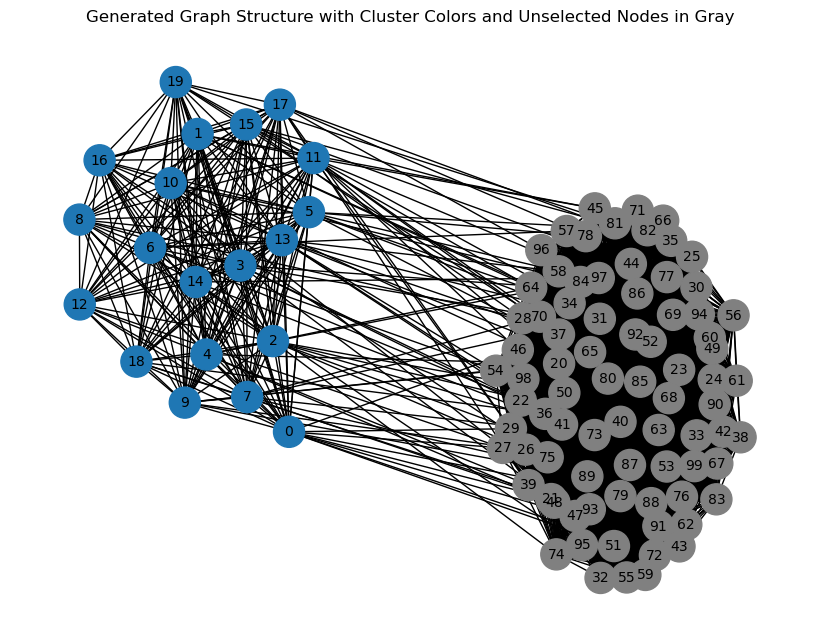

SNR: 8.88809721954225
Check!!!
Execution time (generating the data): 1.705051
Execution time(Before): 1.705244
start!!!
 Iteration   FunEvals Projections     Step Length    Function Val        Opt Cond
         1          2          4     6.67797e-05     2.27776e+01     9.99933e-01
         2          3         11     1.00000e+00     1.74393e+01     1.01408e+00
         3          4         21     1.00000e+00     1.41326e+01     1.03077e+00
         4          5         33     1.00000e+00     1.11786e+01     1.05712e+00
         5          6         45     1.00000e+00     9.05497e+00     1.08338e+00
         6          7         56     1.00000e+00     7.39712e+00     1.12850e+00
         7          8         68     1.00000e+00     6.13990e+00     1.19193e+00
         8          9         80     1.00000e+00     5.18709e+00     1.28107e+00
         9         10         92     1.00000e+00     4.47995e+00     1.35287e+00
        10         11        102     1.00000e+00     3.95849e+00     

In [3]:
from ensem_I import experiment
from L0Obj import L0Obj
import numpy as np

n = 500  # Number of samples
d = 100   # Number of features
k = 20   # Number of non-zero features
h = 1    # Number of clusters
nVars = d*h # Number of Boolean variables in m
theta = 1  # Probability of connection within clusters
gamma = 1.5  # Noise standard deviation
pho = 1/n # divide by sample size 
mu = 1
SNR = 1

fixed_seed = 0
random_rounding = 0
connected = False
correlated = True
random_graph = False
visualize = True
maxIter = 500

mout, X, y, L, clusters_true, selected_features_true, clusters_predict, selected_features_predict = experiment(n, d, k, h, theta, gamma, pho, mu, fixed_seed, random_rounding, connected, correlated, random_graph, visualize, maxIter)
X_hat = np.repeat(X, h, axis=1)
funObj = lambda m: L0Obj(X_hat, m, y, L, pho, mu, d, h)
funObj_separate = lambda m: L0Obj_separate(X_hat, m, y, L, pho, mu, d, h)

In [4]:
print("clusters_true", clusters_true)
print("clusters_predict", clusters_predict)
print("selected_features_true", selected_features_true)
print("selected_features_predict", selected_features_predict)

clusters_true [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])]
clusters_predict {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]}
selected_features_true [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
selected_features_predict [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [5]:
# m_initial = np.random.normal(0, 1, (nVars, 1))
m_initial = np.zeros((nVars, 1))
res_initial = funObj_separate(m_initial)
print("f_initial:", res_initial[0])
print("g_initial:", res_initial[1])
print("graph_penalty_initial:", res_initial[2])
print("precision_penalty_initial:", res_initial[3])
print("A_grad_initial:", res_initial[4])
print("B_grad_initial:", res_initial[5])

f_initial: 22.836015331126188
g_initial: [-7.29604949e+02 -7.35077636e+02 -4.24176243e+02 -2.04296138e+02
 -3.77534749e+02 -6.31074536e+02 -9.05742890e+02 -4.33939624e+02
 -5.68647738e+02 -7.92352368e+02 -5.05261833e+02 -6.05725534e+02
 -3.68513749e+02 -5.19744659e+02 -6.70596207e+02 -5.92975372e+02
 -3.94274354e+02 -5.43669024e+02 -2.70783864e+02 -3.53284822e+02
 -7.12857000e+02 -7.37371813e+02 -3.94264848e+02 -2.05480877e+02
 -1.60493338e+01 -8.66412081e+00 -1.56112447e+02 -1.37417184e+01
 -4.37413926e+01 -1.31867221e+01 -2.86468538e+01 -5.36938744e+01
 -9.70187504e+00 -8.61549816e+00 -2.66174236e+01 -1.28834928e-01
 -4.82834909e+00 -2.43854225e+00 -3.58578244e+01 -1.57089627e+01
 -4.50608128e+00 -6.13008648e+01 -1.82543526e+01 -1.03286980e+01
 -2.82142996e+00 -2.48203077e+01 -1.28267251e+01 -1.94744175e+01
 -1.38951672e+01 -1.15651220e+00 -1.06057878e+02 -1.42307292e+01
 -3.42736163e+00 -9.07601326e+00 -1.04860022e-02 -2.24879152e+00
 -2.89676366e+00 -9.47729592e-01 -2.18024880e+01 

In [6]:
res = funObj_separate(mout)
print("f:", res[0])
print("g:", res[1])
print("graph_penalty:", res[2])
print("precision_penalty:", res[3])
print("A_grad:", res[4])
print("B_grad:", res[5])

f: 3.3091246738384754
g: [-0.63088799 -0.63111834 -0.63120934 -0.63040905 -0.63123793 -0.63115905
 -0.63367178 -0.6312325  -0.63200222 -0.63109202 -0.63179547 -0.63133437
 -0.63210185 -0.63149226 -0.63115719 -0.63086986 -0.63249127 -0.63165148
 -0.63178768 -0.63189951 -0.63195045 -0.62997319 -0.63159261 -0.63259776
 -0.62831802 -0.38536026 -0.6315     -0.6301248  -0.63317364 -0.63277561
 -0.63315963 -0.62999348 -0.63276455 -0.63210251 -0.63287212 -0.63216302
 -0.63211661 -0.62854274 -0.63342078 -0.63230349 -0.63263877 -0.57583216
 -0.63260175 -0.3668896  -0.6326469  -0.51505212 -0.6278318  -0.37566134
 -0.6333107  -0.63317668 -0.63260046 -0.48245018 -0.6295456  -0.63012539
 -0.63243162 -0.38088132 -0.61649155 -0.5382265  -0.63251497 -0.36230352
 -0.41629439 -0.63185778 -0.63332458 -0.62179118 -0.53651812 -0.62979539
 -0.63225701 -0.56696451 -0.6319405  -0.63265374 -0.53237953 -0.47868949
 -0.63287839 -0.63250631 -0.6332108  -0.6321607  -0.6323238  -0.6322922
 -0.63274218 -0.63333822 -0

inter-cluster edge: (0, 29)
inter-cluster edge: (0, 60)
inter-cluster edge: (0, 89)
inter-cluster edge: (0, 91)
inter-cluster edge: (0, 93)
inter-cluster edge: (0, 96)
inter-cluster edge: (1, 25)
inter-cluster edge: (1, 91)
inter-cluster edge: (2, 67)
inter-cluster edge: (2, 69)
inter-cluster edge: (2, 73)
inter-cluster edge: (2, 87)
inter-cluster edge: (3, 30)
inter-cluster edge: (3, 54)
inter-cluster edge: (3, 57)
inter-cluster edge: (3, 72)
inter-cluster edge: (3, 84)
inter-cluster edge: (4, 53)
inter-cluster edge: (4, 74)
inter-cluster edge: (4, 80)
inter-cluster edge: (5, 25)
inter-cluster edge: (5, 34)
inter-cluster edge: (5, 63)
inter-cluster edge: (5, 66)
inter-cluster edge: (5, 77)
inter-cluster edge: (5, 88)
inter-cluster edge: (6, 46)
inter-cluster edge: (6, 58)
inter-cluster edge: (7, 41)
inter-cluster edge: (7, 42)
inter-cluster edge: (7, 43)
inter-cluster edge: (7, 61)
inter-cluster edge: (7, 72)
inter-cluster edge: (7, 74)
inter-cluster edge: (7, 99)
inter-cluster edge: 

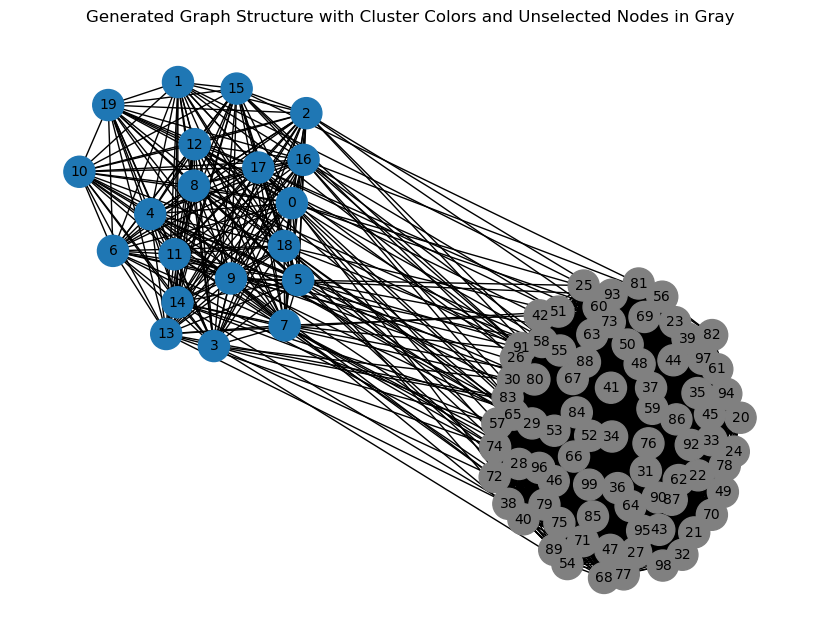

SNR: 9.150308903540726
Check!!!
Execution time (generating the data): 0.36421900000004825
Execution time(Before): 0.36447100000009414
start!!!
 Iteration   FunEvals Projections     Step Length    Function Val        Opt Cond
         1          2          4     7.27201e-05     2.18984e+01     9.99927e-01
         2          3         13     1.00000e+00     1.73986e+01     1.01022e+00
         3          4         23     1.00000e+00     1.40583e+01     1.02543e+00
         4          5         34     1.00000e+00     1.10697e+01     1.04984e+00
         5          6         46     1.00000e+00     8.90193e+00     1.08181e+00
         6          7         58     1.00000e+00     7.22514e+00     1.12682e+00
         7          8         69     1.00000e+00     5.96266e+00     1.17173e+00
         8          9         80     1.00000e+00     5.00179e+00     1.25286e+00
         9         10         92     1.00000e+00     4.27824e+00     1.30740e+00
        10         11        104     1.00000e+

In [ ]:
from ensem_I import experiment
from L0Obj import L0Obj
import numpy as np

n = 500  # Number of samples
d = 100   # Number of features
k = 20   # Number of non-zero features
h = 5    # Number of clusters
nVars = d*h # Number of Boolean variables in m
theta = 1  # Probability of connection within clusters
gamma = 1.5  # Noise standard deviation
pho = np.sqrt(n) # divide by sample size 
mu = 1
SNR = 1

fixed_seed = 0
random_rounding = 0
connected = False
correlated = False
random_graph = True
visualize = True
maxIter = 500

mout, X, y, L, clusters_true, selected_features_true, clusters_predict, selected_features_predict = experiment(n, d, k, h, theta, gamma, pho, mu, fixed_seed, random_rounding, connected, correlated, random_graph, visualize, maxIter)
X_hat = np.repeat(X, h, axis=1)
funObj = lambda m: L0Obj(X_hat, m, y, L, pho, mu, d, h, n)
funObj_separate = lambda m: L0Obj_separate(X_hat, m, y, L, pho, mu, d, h, n)

In [10]:
m_initial = np.random.normal(0, 1, (nVars, 1))
res_initial = funObj_separate(m_initial)
# print("f_initial:", res_initial[0])
# print("g_initial:", res_initial[1])
print("graph_penalty_initial:", res_initial[2])
print("precision_penalty_initial:", res_initial[3])

res = funObj_separate(mout)
# print("f:", res[0])
# print("g:", res[1])
print("graph_penalty:", res[2])
print("precision_penalty:", res[3])

graph_penalty_initial: 0.6690036333710676
precision_penalty_initial: 21927.279228207648
graph_penalty: 0.003350652265357346
precision_penalty: 212902.6350017698


In [4]:
y

array([-3.76220639e+00, -3.85266141e-01, -1.07130882e+00,  1.09380900e+00,
        5.42483538e-01, -3.21321622e-01, -3.13405426e+00,  6.55335427e-01,
        2.82793285e+00, -2.06308416e+00,  6.61108390e-01, -3.65576985e-01,
       -6.25221586e+00, -8.19452610e-01,  9.72538604e-01, -3.80933576e+00,
       -1.12469208e+01,  9.89740079e+00,  4.78365760e+00, -3.74862660e-01,
        9.99481333e-01,  7.47904882e+00,  2.99497939e+00, -1.71430206e+00,
       -1.49971887e+00,  1.41866610e+00,  1.79336025e+00,  4.19517105e+00,
        1.20747024e+00,  6.16942989e+00,  1.53137978e+00, -2.42574321e+00,
       -1.12904237e+00,  7.52477404e+00, -4.50423214e+00,  8.74325030e+00,
       -4.77309151e+00, -3.53672862e+00,  1.20235058e+00,  2.31739107e+00,
        3.71251547e+00, -6.58783159e+00, -4.24141733e+00, -6.13084430e+00,
       -9.85593855e+00,  3.47043413e+00,  1.71378218e-01,  6.68445095e+00,
        2.94071202e+00, -1.41372367e-01, -4.63763415e+00,  6.31154805e+00,
       -5.54931059e+00,  

In [31]:
mout

array([4.01230051e-02, 4.30790955e-02, 4.23831550e-02, 4.38293631e-02,
       4.86134898e-02, 4.16018148e-02, 4.48128544e-02, 3.99336329e-02,
       4.34218152e-02, 4.63248204e-02, 4.90170710e-02, 4.28880088e-02,
       4.27756720e-02, 4.46423962e-02, 4.14700161e-02, 4.25041395e-02,
       4.17866326e-02, 4.04565636e-02, 4.56243007e-02, 4.60864702e-02,
       3.03581131e-03, 3.10775546e-03, 2.99427168e-03, 1.79839510e-03,
       1.84866761e-03, 3.02874777e-03, 1.33738920e-03, 2.03624269e-11,
       2.85349756e-03, 2.87176120e-03, 5.11708863e-03, 2.77244536e-11,
       3.16380809e-04, 2.25306529e-03, 2.00965632e-10, 3.78425526e-11,
       2.18858959e-03, 3.94489090e-04, 1.60865502e-03, 2.12114428e-11,
       2.33213266e-03, 8.11950572e-11, 3.79454863e-10, 7.75353088e-04,
       1.32905613e-08, 2.89206615e-03, 4.67201460e-03, 3.01463315e-03,
       1.97248443e-11, 3.06641680e-11, 5.11651657e-03, 1.03368436e-03,
       9.38507847e-08, 1.61213612e-03, 1.00357988e-03, 1.68542892e-10,
      

In [33]:
mout.shape

(100,)

In [28]:
a = mout.reshape(d,h)
print(a)

[[3.85750297e-02]
 [4.22520026e-02]
 [3.61107004e-02]
 [4.13813357e-02]
 [4.26161182e-02]
 [4.04134963e-02]
 [4.53193149e-02]
 [4.20621700e-02]
 [4.72085853e-02]
 [4.47854715e-02]
 [4.27663113e-02]
 [3.75117051e-02]
 [4.73678612e-02]
 [4.01445745e-02]
 [4.43164787e-02]
 [4.42948836e-02]
 [4.44841515e-02]
 [4.37664678e-02]
 [4.59040684e-02]
 [4.42071617e-02]
 [5.54021179e-03]
 [1.99293932e-03]
 [3.07974728e-03]
 [3.41254915e-03]
 [5.19346734e-04]
 [9.98755118e-10]
 [1.95755402e-03]
 [7.67855195e-04]
 [2.75482641e-03]
 [3.08055868e-03]
 [2.15334260e-03]
 [1.77774117e-03]
 [3.53085298e-03]
 [1.60511946e-03]
 [3.18104215e-04]
 [2.00716666e-03]
 [1.69916676e-03]
 [1.90156733e-03]
 [3.20010608e-03]
 [1.73851716e-03]
 [9.60698873e-04]
 [6.17673872e-07]
 [2.98432503e-03]
 [7.92613673e-10]
 [4.93131251e-04]
 [1.61999211e-08]
 [6.02568463e-04]
 [8.81554450e-10]
 [3.02347758e-03]
 [2.10297825e-03]
 [5.25580438e-04]
 [5.99924776e-09]
 [3.20169636e-03]
 [1.46432570e-03]
 [2.19496529e-04]
 [9.364305

In [34]:
T = 1000
min_obj = np.inf
min_round = np.zeros((nVars, ))  # initialize the best result
scaled_mout = 10 * mout
m_grouped = scaled_mout.reshape(d, h)
"""
here we propose a different way to round this result. note that we have introduce h times more variables than the original problem. so the number are diluted, it is hard to get more than a lot of ones in the result if we round it according to its probability. because even the selected one are very small.

so we need to, first, treat variables associated with the same feature as a whole, take the sum, and then round it according to the probability to determine whether this feature is selected or not. Then, for the selected features, we need to determine which cluster it belongs to according to the probability.
"""
for _ in range(T):
    one_realization = np.zeros((d, h))
    feature_round = (np.random.rand(d)<np.sum(m_grouped, axis=1)).astype(int)

    for i in range(d):
        if feature_round[i] == 1:
            cluster = np.random.choice(h, p=m_grouped[i]/np.sum(m_grouped[i])) # TODO: another choice is to introduce a temperature parameter to control the randomness or an extra "discard" choice with the 1- sum(m_grouped[i]) probability
            one_realization[i, cluster] = 1

    m_round = one_realization.flatten()
    obj = funObj(m_round)[0]
    if obj < min_obj:
        min_obj = obj
        min_round = m_round

selected_features_predict = []
clusters_predict = {}
# parse the result m_round to the selected features and clusters
m = min_round.reshape(d, h)
for i in range(d):
    if np.sum(m[i]) > 0:
        selected_features_predict.append(i)
        cluster = np.where(m[i] > 0)[0][0]
        if cluster in clusters_predict:
            clusters_predict[cluster].append(i)
        else:
            clusters_predict[cluster] = [i]

In [35]:
clusters_predict = {}

In [36]:
m

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [2]:
mout.sum()

0.9999999959072199

cluster: [56 14 87  0], feature_weight: -0.26574334048280934
cluster: [62 58 15 75], feature_weight: 0.14063173633810666
cluster: [ 3 68  5 46], feature_weight: 1.8595119262125326
cluster: [53 65 99 36], feature_weight: -0.034005193733036426
cluster: [ 1 22 33 64], feature_weight: 0.6051849523342304


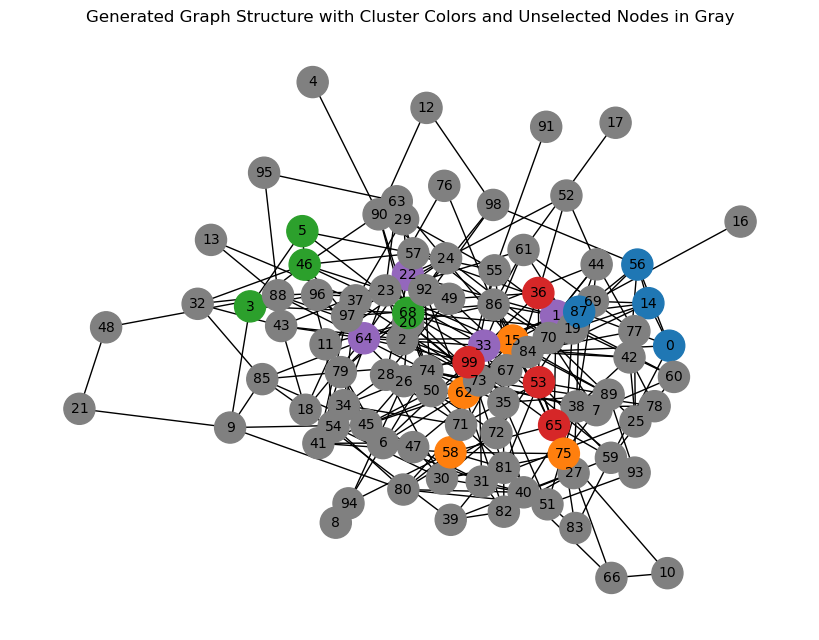

SNR: 8.81456567988196
Check!!!
Execution time (generating the data): 1.188703
Execution time(Before): 1.188842
start!!!
 Iteration   FunEvals Projections     Step Length    Function Val        Opt Cond
         1          2          4     2.14635e-01     1.82192e+01     7.85365e-01
         2          3         13     1.00000e+00     1.81111e+01     6.03302e-02
         3          4         21     1.00000e+00     1.81111e+01     1.95587e-02
         4          5         27     1.00000e+00     1.81111e+01     5.76168e-04
Directional Derivative below optTol
clusters_predict {0: [5, 3, 68, 46, 57, 64, 22, 96, 9, 23, 1, 35, 97, 32, 79, 11, 90, 67, 92, 19]}
Accuracy of PQN: 0.35


In [1]:

from ensem_I import experiment
from L0Obj import L0Obj
import numpy as np

n = 500  # Number of samples
d = 100   # Number of features
k = 20   # Number of non-zero features
h = 5    # Number of clusters
nVars = d*h # Number of Boolean variables in m
theta = 0.9  # Probability of connection within clusters
gamma = 1.5  # Noise standard deviation
pho = np.sqrt(n) # divide by sample size 
mu = 1
SNR = 1

fixed_seed = 0
random_rounding = 0
connected = False
correlated = False
random_graph = True
visualize = True
maxIter = 500

mout, X, y, L, clusters_true, selected_features_true, clusters_predict, selected_features_predict = experiment(n, d, k, h, theta, gamma, pho, mu, fixed_seed, random_rounding, connected, correlated, random_graph, visualize, maxIter)
X_hat = np.repeat(X, h, axis=1)
funObj = lambda m: L0Obj(X_hat, m, y, L, pho, mu, d, h, n)
funObj_separate = lambda m: L0Obj_separate(X_hat, m, y, L, pho, mu, d, h, n)
        


In [ ]:
clusters_true
# generate m according the groud-truth clusters
m = np.zeros((d, h))
for i in range(d):
    cluster = np.random.choice(h, p=clusters_true[i])
    m[i, cluster] = 1

[array([44, 39, 46, 45]),
 array([76, 18,  4, 28]),
 array([31, 85, 21,  1]),
 array([43, 23, 84,  6]),
 array([90, 92, 22, 61])]

In [2]:
L

<100x100 sparse matrix of type '<class 'numpy.float64'>'
	with 160 stored elements in Compressed Sparse Row format>

In [4]:
M = np.zeros((d, h))
for j in range(h):
    for i in clusters_true[j]:
        M[i, j] = 1

# compute the graph penalty term
graph_penalty = mu * np.trace(M.T @ L @ M)
print("graph_penalty:", graph_penalty)


graph_penalty: 12.162888672295677


In [10]:
d = 10
h = 5
for j in range(h):
    B_row = np.zeros(d*h)
    # Set every d-th element in the row to 1
    B_row[j:d*h:h] = -1
    print(B_row)

[-1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.
  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.
  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
[ 0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.
  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0.
 -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.]
[ 0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.
  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.
  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.]
[ 0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0.
 -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.
  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.]
[ 0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.
  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.
  0.  0.  0. -1.  0.  0.  0.  0. -1.  

In [3]:
M_relaxed = mout.reshape(d, h)

# compute the graph penalty term
graph_penalty = mu * np.trace(M_relaxed.T @ L @ M_relaxed)
print("graph_penalty:", graph_penalty)

graph_penalty: 0.028157486169644752


In [8]:
M_average = np.zeros((d, h))
for i in selected_features_true:
    for j in range(h):
        M_average[i, j] = 1/h

# compute the graph penalty term
graph_penalty = mu * np.trace(M_average.T @ L @ M_average)
print("graph_penalty:", graph_penalty)

graph_penalty: -1.4571677198205182e-15


In [10]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 11.5 MB/s eta 0:00:00 0:00:01


Text(0.5, 1.0, 'Laplacian Matrix Heatmap')

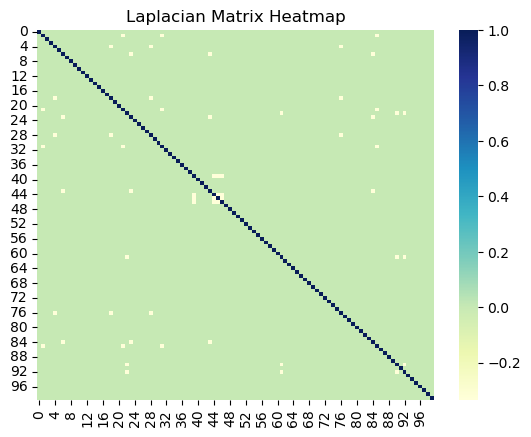

In [11]:
# heatmap of L
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(L.toarray(), cmap="YlGnBu")
plt.title("Laplacian Matrix Heatmap")

In [82]:
A = np.ones((1, d*h))
print(A)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [ ]:
from gurobipy import Model, Env
import numpy as np
def ProjOperator_Gurobi(m, k, d, h):
    """
    This function we return a projection operator that projects the input vector m onto the simplex
    Parameters:
    - m: input vector (maybe in it matrix form -- no)
    - k: sparsity level
    - d: number of features
    - h: number of pre-defined clusters, which can be read from the input vector m (omit for now, since we pass the vector form, so we cannot know d and h directly)
    """
    # print("m", m.shape)
    # Create constraint matrix A for the sparsity level
    A = np.ones((1, d*h))
    b = np.array([k])

    # Create constraint matrix B for each feature belongs to at most one cluster
    # Initialize B as an empty matrix with shape (0, d*h)
    B = np.empty((0, d*h))

    # Initialize c as an empty array
    c = np.empty((0, 1))

    for i in range(d):
        # Create a new row of zeros with shape (1, d*h)
        B_row = np.zeros(d*h)
        # Set a specific element in the row to 1
        B_row[i*h: (i+1)*h] = 1

        # Stack the new row onto B
        B = np.vstack([B, B_row]) 

        # Append 1 to vector c
        c = np.vstack([c, [[1]]])

    # also i want to add the constraint that each cluster should have at least one feature
    Cluster = np.empty((0, d*h))
    Cluster_b = np.empty((0, 1))
    for j in range(h):
        # Create a new row of zeros with shape (1, d*h)
        Cluster_row = np.zeros(d*h)
        # Set every d-th element in the row to 1
        Cluster_row[j:d*h:h] = 1

        # Stack the new row onto B
        Cluster = np.vstack([Cluster, Cluster_row])

        Cluster_b = np.vstack([Cluster_b, [[1]]])

    # Concatenate A and B to create the constraint matrix
    C = np.vstack([A, B])
    Cb = np.vstack([b, c])
    # print("C", C.shape, C)
    # print("Cb", Cb.shape, Cb)
    # print(C)
    # print(Cb)

    with Env(empty=True) as env:
        env.setParam('OutputFlag', 0) # I want to suppress the annoying license message
        env.start()
        with Model(env=env) as model:
            # Set Gurobi parameters
            # model.setParam('OutputFlag', 0)
            # model.setParam('IterationLimit', 500)

            # Add variables
            x = model.addMVar(d*h, lb=0.0, ub=1.0)

            # Set objective function
            Q = np.eye(d*h)
            f = -2*m.flatten()
            # print("x", x.shape)
            # print("f", f.shape)
            model.setObjective(0)
            model.addConstr(C @ x <= Cb)
            model.addConstr(Cluster @ x >= Cluster_b)

            # Optimize model
            model.optimize()
            print("Model status:", model.Status)

            model.write("full_model.lp")  # or 
            # model.write("full_model.mps")

            # for var in model.getVars():
            #     print(var.VarName, var.LB, var.UB, var.VType)

            model.printStats()


            model.computeIIS() 
            model.write("infeasibility_report.ilp")


            # Get the results
            x = x.x
    return x


In [30]:
d = 20   # Number of features
k = 10   # Number of non-zero features
h = 5    # Number of clusters
m = np.zeros((d*h, 1))
m[:k] = 1 


model, x = ProjOperator_Gurobi(m, k, d, h)

Model status: 3


In [26]:
model.computeIIS() 
model.write("infeasibility_report.ilp")

AttributeError: 'NoneType' object has no attribute '_async_in_progress'

In [37]:
def random_partition(d, h_total):
    """
    Randomly partition `d` into `h_total` parts, ensuring the sum equals `d`.
    
    Parameters:
    - d (int): Total number to partition.
    - h_total (int): Number of parts/clusters.

    Returns:
    - list: A list of breakpoints that divide the range [0, d] into `h_total` parts.
    """
    if d < h_total:
        raise ValueError("The number of clusters exceeds the total number.") 
    # Generate `h_total - 1` random breakpoints in the range [0, d]
    breakpoints = sorted(np.random.choice(range(1, d), h_total - 1, replace=False))
    
    # Add the boundaries (0 and d) to the breakpoints
    breakpoints = [0] + breakpoints + [d]

    # print("cluster 0 contains features from 0 to", breakpoints[1] - 1)  
    for i in range(h_total):
        print(f"cluster {i} contains features from {breakpoints[i]} to {breakpoints[i + 1] - 1}")

    
    return breakpoints

random_partition(200, 5)

cluster 0 contains features from 0 to 80
cluster 1 contains features from 81 to 107
cluster 2 contains features from 108 to 152
cluster 3 contains features from 153 to 197
cluster 4 contains features from 198 to 199


[0, 81, 108, 153, 198, 200]

In [33]:
# optimization problemfrom gurobipy import Model, Env
import numpy as np

def ProjOperator_Gurobi(m, k, d, h):
    """
    This function projects the input vector m onto the simplex while satisfying constraints.
    Parameters:
    - m: input vector
    - k: sparsity level (number of non-zero entries allowed)
    - d: number of features
    - h: number of clusters
    """
    A = np.ones((1, d * h))  # Sparsity constraint matrix
    b = np.array([k])        # Sparsity constraint vector

    # Feature assignment constraints
    B = np.zeros((d, d * h))
    for i in range(d):
        B[i, i * h:(i + 1) * h] = 1
    c = np.ones((d, 1))

    # Cluster coverage constraints
    Cluster = np.zeros((h, d * h))
    for j in range(h):
        Cluster[j, j::h] = 1
    Cluster_b = np.ones((h, 1))

    # Combine all constraints
    C = np.vstack([A, B])
    Cb = np.vstack([b, c])

    with Env(empty=True) as env:
        env.setParam('OutputFlag', 0)  # Suppress output
        env.start()
        with Model(env=env) as model:
            # Add variables
            x = model.addMVar(d * h, lb=0.0, ub=1.0)

            # Objective function (quadratic)
            Q = np.eye(d * h)
            f = -2 * m.flatten()
            model.setObjective(x @ Q @ x + f @ x, sense=1)  # Minimize

            # Add constraints
            model.addConstr(C @ x <= Cb.flatten(), name="GeneralConstraints")
            model.addConstr(Cluster @ x >= Cluster_b.flatten(), name="ClusterCoverage")

            # Optimize
            model.optimize()

            # Debugging infeasibility
            if model.Status == 3:  # Infeasible
                print("Model is infeasible. Writing infeasibility report...")
                model.computeIIS()
                model.write("infeasibility_report.ilp")
                return None

            # Return solution
            return x.x


d = 20   # Number of features
k = 10   # Number of non-zero features
h = 5    # Number of clusters
m = np.zeros((d*h, 1))

res = ProjOperator_Gurobi(m, k, d, h)


In [34]:
res

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05])

cluster 0 contains features from 0 to 56, with size 57
cluster 1 contains features from 57 to 74, with size 18
cluster 2 contains features from 75 to 80, with size 6
cluster 3 contains features from 81 to 87, with size 7
cluster 4 contains features from 88 to 99, with size 12


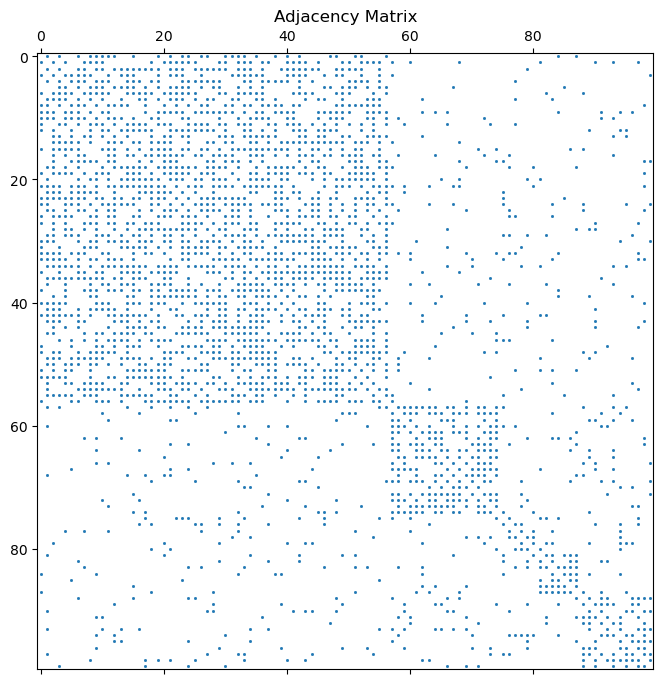

Adjacency matrix created.


In [43]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

def random_partition(d, h_total):
    """
    Randomly partition `d` into `h_total` parts, ensuring the sum equals `d`.
    """
    if d < h_total:
        raise ValueError("The number of clusters exceeds the total number.") 
    # Generate `h_total - 1` random breakpoints in the range [0, d]
    breakpoints = sorted(np.random.choice(range(1, d), h_total - 1, replace=False))
    
    # Add the boundaries (0 and d) to the breakpoints
    breakpoints = [0] + breakpoints + [d]

    for i in range(h_total):
        print(f"cluster {i} contains features from {breakpoints[i]} to {breakpoints[i + 1] - 1}, with size {breakpoints[i + 1] - breakpoints[i]}")
    
    return breakpoints

def generate_random_graph(d, h_total, h, inter_cluster_prob, outer_cluster_prob, connected=False, visualize=True):
    """
    Generate a random graph adjacency matrix with the specified cluster properties.
    
    Parameters:
    - d (int): Total number of nodes.
    - h_total (int): Total number of clusters.
    - h (int): Number of selected clusters.
    - inter_cluster_prob (float): Probability of edges within selected clusters.
    - outer_cluster_prob (float): Probability of edges outside selected clusters.
    - connected (bool): If True, ensures the graph is connected.
    - visualize (bool): If True, visualizes the adjacency matrix.

    Returns:
    - scipy.sparse.csr_matrix: The resulting adjacency matrix.
    """
    # Randomly partition `d` into `h_total` parts
    breakpoints = random_partition(d, h_total)
    clusters = [range(breakpoints[i], breakpoints[i + 1]) for i in range(h_total)]

    # Selected clusters
    selected_clusters = clusters[:h]

    # Initialize sparse adjacency matrix
    adj_matrix = sp.lil_matrix((d, d), dtype=int)

    # Fill adjacency matrix for selected clusters
    for cluster in clusters:
        size = len(cluster)
        block = (np.random.rand(size, size) < inter_cluster_prob).astype(int)
        np.fill_diagonal(block, 0)  # No self-loops
        block = np.triu(block, k=1) + np.triu(block, k=1).T  # Symmetrize
        for i, node_i in enumerate(cluster):
            for j, node_j in enumerate(cluster):
                adj_matrix[node_i, node_j] = block[i, j]

    # Fill adjacency matrix for outer clusters
    for i in range(h_total):
        for j in range(i + 1, h_total):
            cluster_i = clusters[i]
            cluster_j = clusters[j]
            block = (np.random.rand(len(cluster_i), len(cluster_j)) < outer_cluster_prob).astype(int)
            for m, node_i in enumerate(cluster_i):
                for n, node_j in enumerate(cluster_j):
                    adj_matrix[node_i, node_j] = block[m, n]
                    adj_matrix[node_j, node_i] = block[m, n]  # Symmetry

    # Ensure graph is connected (optional)
    if connected:
        for i in range(d - 1):
            adj_matrix[i, i + 1] = 1
            adj_matrix[i + 1, i] = 1

    # Convert to CSR format
    adj_matrix = adj_matrix.tocsr()

    # Visualize the adjacency matrix
    if visualize:
        plt.figure(figsize=(8, 8))
        plt.spy(adj_matrix, markersize=1)
        plt.title("Adjacency Matrix")
        plt.show()

    return adj_matrix

# Example usage
d = 100  # Total nodes
h_total = 5  # Total clusters
h = 3  # Selected clusters
inter_cluster_prob = 0.6  # Probability of edges within selected clusters
outer_cluster_prob = 0.1  # Probability of edges outside selected clusters

adj_matrix = generate_random_graph(d, h_total, h, inter_cluster_prob, outer_cluster_prob, connected=True, visualize=True)

print("Adjacency matrix created.")

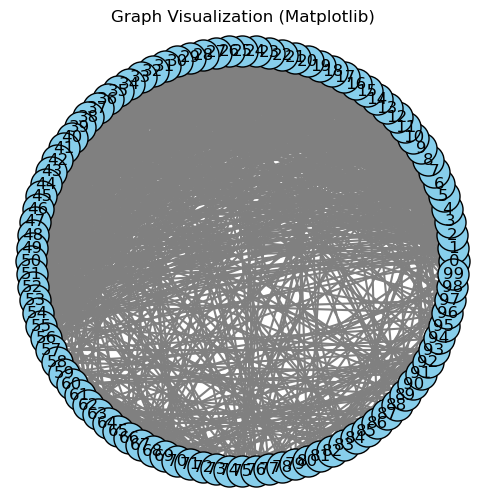

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# # Example adjacency matrix
# adj_matrix = np.array([
#     [0, 1, 0, 1],
#     [1, 0, 1, 0],
#     [0, 1, 0, 1],
#     [1, 0, 1, 0]
# ])

# Positions for nodes (circle layout)
num_nodes = adj_matrix.shape[0]
angles = np.linspace(0, 2 * np.pi, num_nodes, endpoint=False)
node_positions = {i: (np.cos(angle), np.sin(angle)) for i, angle in enumerate(angles)}

# Plot the graph
plt.figure(figsize=(6, 6))
for i in range(num_nodes):
    x, y = node_positions[i]
    plt.scatter(x, y, s=500, c='skyblue', edgecolors='k', zorder=2)
    plt.text(x, y, str(i), fontsize=12, ha='center', va='center', zorder=3)

# Draw edges
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if adj_matrix[i, j] == 1:
            x_values = [node_positions[i][0], node_positions[j][0]]
            y_values = [node_positions[i][1], node_positions[j][1]]
            plt.plot(x_values, y_values, 'gray', zorder=1)

plt.axis('off')
plt.title("Graph Visualization (Matplotlib)")
plt.show()

In [ ]:
# # Create a graph
# G = nx.Graph()

# # Define nodes (0-based indexing)
# nodes = range(d)
# G.add_nodes_from(nodes)

# # Add edges for the first cluster (0, 1, 2, 3)
# G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0), (0, 2), (1, 3)])

# # Add edges for the second cluster (4, 5, 6)
# G.add_edges_from([(4, 5), (5, 6), (6, 4)])

# # Connect the two clusters with an edge between nodes 3 and 4
# G.add_edge(3, 4)

# # Create adjacency matrix
# adj_matrix = nx.to_scipy_sparse_array(G, format="csr")

# # Compute the Laplacian matrix
# degree_matrix = sp.diags(np.ravel(adj_matrix.sum(axis=1)))
# laplacian_matrix = degree_matrix - adj_matrix

# # Define clusters explicitly
# clusters = [[0, 1, 2, 3], [4, 5, 6]]

# # Define the regression weight vector
# w = np.zeros(d)
# selected_features = [0, 1, 2, 3]  # Selected features (adjusted for 0-based indexing)
# feature_value = 1.0  # Assign the same weight to all selected features

In [ ]:
import numpy as np

def construct_difference_matrix(m, n):
    """
    Construct the difference matrix D for variables indexed by (i, j) where
    there are m rows and n columns.

    Args:
        m: Number of rows (i index). here it is the d, number of features
        n: Number of columns (j index). here it is the h, number of clusters

    Returns:
        D: A sparse matrix of shape ((m * (n-1)) x (m * n)) representing the
           pairwise differences (x_{i,j} - x_{i,j-1}).
    """
    from scipy.sparse import lil_matrix

    # Number of rows in D is m * (n-1) (differences per row)
    # Number of columns in D is m * n (variables total)
    num_rows = m * (n - 1)
    num_cols = m * n

    # Initialize the sparse matrix
    D = lil_matrix((num_rows, num_cols))

    # Fill the matrix with +1 and -1 for each difference x_{i,j} - x_{i,j-1}
    for i in range(m):
        for j in range(1, n):
            row_idx = i * (n - 1) + (j - 1)  # Row in D
            col_plus = i * n + j            # x_{i,j} position (+1)
            col_minus = i * n + (j - 1)     # x_{i,j-1} position (-1)

            D[row_idx, col_plus] = 1
            D[row_idx, col_minus] = -1

    return D.tocsr()  # Convert to CSR format for efficient use in solvers

# Example usage
m = 3  # Number of rows (i index)
n = 4  # Number of columns (j index)
D = construct_difference_matrix(m, n)
print(D.toarray())  # Convert to dense array to visualize (optional)


[[-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.]]


In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

# Define a model
model = gp.Model()

# Number of variables
n = 10
C = 5.0

# Define variables
x = model.addVars(n, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="x")

# Define the quadratic matrix Q (example: identity matrix)
Q = np.eye(n)

# Add the quadratic constraint
model.addQConstr(gp.quicksum(Q[i, j] * x[i] * x[j] for i in range(n) for j in range(n)) >= C)

# Fix variables to a given point
point = np.random.randn(n)  # Replace with the point you want to check
for i in range(n):
    x[i].lb = point[i]
    x[i].ub = point[i]

# Optimize
model.optimize()

# Check feasibility
if model.Status == GRB.OPTIMAL:
    print("Point is feasible.")
else:
    print("Point is not feasible.")


In [5]:
import numpy as np
d = 10
h = 5
# m = np.zeros((d*h, 1))
M = np.zeros((d, h))
for i in range(d):
    # choose a cluster randomly
    cluster = np.random.choice(h)
    M[i, cluster] = 1

print(M)

[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [6]:
# M = m.reshape(d, h)
C = 1
# M = 0.2 * np.ones((d, h))
# Step 1: Compute M M^T (row-wise sums of all pairwise products)
MTM = np.dot(M.T, M)
correction_term = np.sum(MTM) - np.sum(np.diag(MTM))
print(correction_term)
# Step 1: Compute row-wise sums
row_sums = np.sum(M, axis=1, keepdims=True)  # Shape (n_rows, 1)

# Step 2: Compute the gradient
gradient = 2 * (row_sums - M)

# correction_term = C * np.sum(m**2)
print(gradient)


0.0
[[2. 2. 2. 0. 2.]
 [0. 2. 2. 2. 2.]
 [2. 2. 0. 2. 2.]
 [2. 2. 2. 0. 2.]
 [0. 2. 2. 2. 2.]
 [0. 2. 2. 2. 2.]
 [2. 2. 2. 2. 0.]
 [2. 2. 0. 2. 2.]
 [2. 0. 2. 2. 2.]
 [2. 2. 2. 0. 2.]]


In [86]:
MTM = np.dot(M.T, M)
correction_term = np.sum(MTM) - np.sum(np.diag(MTM))
print(correction_term)

8.0


In [9]:
import numpy as np

def vector_to_symmetric(vec, n):
    """
    Convert a vector of independent variables to a symmetric matrix.
    
    Parameters:
    - vec: A flat vector containing the upper triangular entries of the matrix.
    - n: The dimension of the square symmetric matrix.
    
    Returns:
    - A symmetric matrix of shape (n, n).
    """
    sym_matrix = np.zeros((n, n))
    upper_indices = np.triu_indices(n)
    sym_matrix[upper_indices] = vec
    sym_matrix = sym_matrix + sym_matrix.T - np.diag(np.diag(sym_matrix))
    return sym_matrix

def symmetric_to_vector(matrix):
    """
    Extract the upper triangular entries of a symmetric matrix as a vector.
    
    Parameters:
    - matrix: A symmetric matrix.
    
    Returns:
    - A flat vector of the independent entries.
    """
    n = matrix.shape[0]
    upper_indices = np.triu_indices(n)
    return matrix[upper_indices]

def objective_function(vec, n):
    """
    Example objective function with a symmetric matrix.
    
    Parameters:
    - vec: Flat vector of independent variables (upper triangular entries).
    - n: The dimension of the square symmetric matrix.
    
    Returns:
    - The computed objective value.
    """
    sym_matrix = vector_to_symmetric(vec, n)
    # Example: Sum of all squared elements of the symmetric matrix
    return np.sum(sym_matrix**2)

# Example usage
n = 4  # Size of the symmetric matrix
vec = np.random.rand((n * (n + 1)) // 2)  # Independent variables (upper triangular entries)

# Compute objective
# objective = objective_function(vec, n)
print("vec:", vec)
print("matrix:",  vector_to_symmetric(vec, n))

vec: [0.43705891 0.9461342  0.64766779 0.53905801 0.51813114 0.20996078
 0.83788864 0.54070595 0.00554355 0.90701691]
matrix: [[0.43705891 0.9461342  0.64766779 0.53905801]
 [0.9461342  0.51813114 0.20996078 0.83788864]
 [0.64766779 0.20996078 0.54070595 0.00554355]
 [0.53905801 0.83788864 0.00554355 0.90701691]]


In [10]:
import numpy as np

def vector_to_symmetric(vec, n):
    """
    Convert a vector of independent variables to a symmetric matrix.
    """
    sym_matrix = np.zeros((n, n), dtype=int)
    upper_indices = np.triu_indices(n)
    sym_matrix[upper_indices] = vec
    sym_matrix = sym_matrix + sym_matrix.T - np.diag(np.diag(sym_matrix))
    return sym_matrix

def compute_upper_triangle_product(L, vec, n):
    """
    Compute the product L_ij * y_ij for the upper triangular part of the symmetric matrix.
    """
    # Reconstruct the symmetric matrix from the vector
    sym_matrix = vector_to_symmetric(vec, n)
    
    # Extract the upper triangular indices
    upper_indices = np.triu_indices(n)
    
    # Compute L_ij * y_ij for upper triangular elements
    product_upper = L[upper_indices] * sym_matrix[upper_indices]
    
    # Return the product as a flat vector
    return product_upper

# Example
n = 3  # Dimension of the symmetric matrix

# Define L as a symmetric matrix
L = np.array([
    [1, 2, 3],
    [2, 4, 5],
    [3, 5, 6]
])

# Define vec as the upper triangular entries of a symmetric matrix
vec = np.array([1, 0, 1, 0, 1, 0])  # Corresponds to the symmetric matrix:
# [[1, 0, 1],
#  [0, 1, 0],
#  [1, 0, 0]]

# Compute the product
upper_product = compute_upper_triangle_product(L, vec, n)

# Print results
print("Matrix L:")
print(L)
print("\nReconstructed symmetric matrix from vec:")
print(vector_to_symmetric(vec, n))
print("\nFlattened upper triangular product vector (L_ij * y_ij):")
print(upper_product)

Matrix L:
[[1 2 3]
 [2 4 5]
 [3 5 6]]

Reconstructed symmetric matrix from vec:
[[1 0 1]
 [0 0 1]
 [1 1 0]]

Flattened upper triangular product vector (L_ij * y_ij):
[1 0 3 0 5 0]


In [11]:
import numpy as np
from gurobipy import Model, GRB, quicksum

def projection_operator_upper_triangle(vec, n, k):
    """
    Projects the upper triangular part of a matrix represented by 'vec'
    onto the constraint set:
    - sum(y_ii) <= k
    - 0 < y_ij < 1 for all elements
    
    Parameters:
    - vec: (n * (n + 1)) / 2 numpy array, upper triangular part of the matrix.
    - n: Integer, size of the matrix (n x n).
    - k: Integer, maximum sum of diagonal elements.
    
    Returns:
    - vec_proj: Projected upper triangular part as a flattened vector.
    """
    # Reconstruct the full matrix from the upper triangular vector
    Y = np.zeros((n, n))
    indices = np.triu_indices(n)
    Y[indices] = vec
    Y = Y + Y.T - np.diag(np.diag(Y))  # Fill lower triangular to make symmetric

    # Gurobi optimization
    model = Model("Projection")
    model.setParam("OutputFlag", 0)  # Suppress Gurobi output

    # Define variables for upper triangular part
    y = model.addVars(n, n, lb=0, ub=1, vtype=GRB.CONTINUOUS, name="y")

    # Objective: Minimize ||Y - y||_F^2
    model.setObjective(
        quicksum((Y[i, j] - y[i, j]) ** 2 for i in range(n) for j in range(i, n)),
        GRB.MINIMIZE
    )

    # Constraint 1: sum(y_ii) <= k
    model.addConstr(quicksum(y[i, i] for i in range(n)) <= k, name="DiagonalSum")

    # Optimize the model
    model.optimize()

    # Extract the projected matrix
    Y_proj = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            Y_proj[i, j] = y[i, j].x
            Y_proj[j, i] = Y_proj[i, j]  # Symmetric

    # Extract the upper triangular part of the projected matrix
    vec_proj = Y_proj[indices]

    return vec_proj

# Example usage
n = 4  # Matrix size
k = 2  # Sum of diagonal constraint

# Example input vector (upper triangular part of the matrix)
vec = np.array([0.8, 0.5, 0.2, 0.4, 0.6, 0.7, 0.3, 0.9, 0.8, 0.5])

vec_proj = projection_operator_upper_triangle(vec, n, k)
print("Original upper triangular vector:")
print(vec)
print("\nProjected upper triangular vector:")
print(vec_proj)

Set parameter Username
Set parameter LicenseID to value 2585252
Set parameter LogToConsole to value 0
Original upper triangular vector:
[0.8 0.5 0.2 0.4 0.6 0.7 0.3 0.9 0.8 0.5]

Projected upper triangular vector:
[0.6 0.5 0.2 0.4 0.4 0.7 0.3 0.7 0.8 0.3]


In [12]:
print(500 * 501//2)

125250


In [13]:
Xs = np.array([
    [1, 1, 0, 0],
    [1, 1, 1, 0],
    [0, 1, 1, 1],
    [0, 0, 1, 1]
])

i = 1  # We are checking the relationships for feature 1
Xs_ij = Xs[i, :]  # Extract the i-th row
buddy = np.where(Xs_ij == 1)[0]  # Get the indices of features in the same cluster
print("Row:", Xs_ij)
print("Buddy indices:", buddy)

Row: [1 1 1 0]
Buddy indices: [0 1 2]


In [14]:
def vector_to_symmetric(vec, n):
    """
    Convert a vector of independent variables to a symmetric matrix.
    
    Parameters:
    - vec: A flat vector containing the upper triangular entries of the matrix.
    - n: The dimension of the square symmetric matrix.
    
    Returns:
    - A symmetric matrix of shape (n, n).
    """
    sym_matrix = np.zeros((n, n))
    upper_indices = np.triu_indices(n)
    sym_matrix[upper_indices] = vec
    sym_matrix = sym_matrix + sym_matrix.T - np.diag(np.diag(sym_matrix))
    return sym_matrix

def symmetric_to_vector(matrix):
    """
    Extract the upper triangular entries of a symmetric matrix as a vector.
    
    Parameters:
    - matrix: A symmetric matrix.
    
    Returns:
    - A flat vector of the independent entries.
    """
    n = matrix.shape[0]
    upper_indices = np.triu_indices(n)
    return matrix[upper_indices]


In [44]:
import numpy as np
import scipy.io as sio
Xs_out = sio.loadmat("Xs_out.mat")["Xs_out"]

Xs = vector_to_symmetric(Xs_out, 500)


In [47]:
print(Xs[:5, :5])   

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [48]:
print(np.diag(Xs))

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.99999797 1.
 1.         1.         1.         1.         1.         1.
 1.         0.99999999 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.67715827
 0.63965588 0.59658693 0.61322264 0.65407512 0.62802866 0.60998185
 0.57051293 0.63448865 0.61820188 0.60728501 0.62383956 0.60410057
 0.62487718 0.60698872 0.63368641 0.60740782 0.61455232 0.62571443
 0.66667722 0.68775957 0

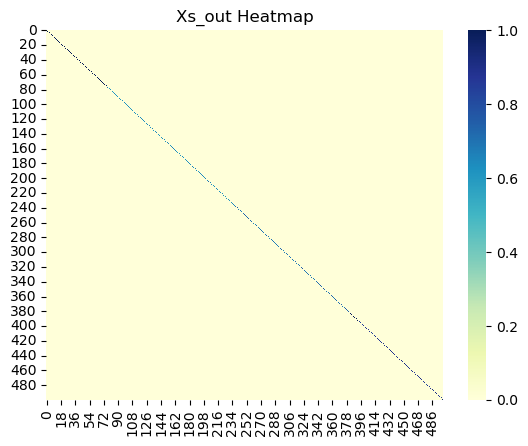

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot a heatmap of the Xs_out matrix

sns.heatmap(Xs, cmap="YlGnBu")
plt.title("Xs_out Heatmap")

plt.show()

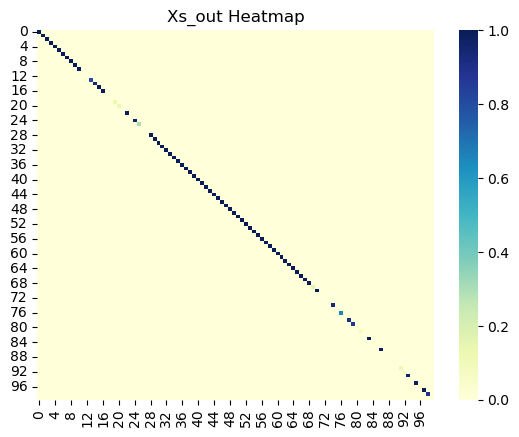

In [52]:
import numpy as np
import scipy.io as sio
Xs_out = sio.loadmat("Xs_out.mat")["Xs_out"]

Xs = vector_to_symmetric(Xs_out, 100)
sns.heatmap(Xs, cmap="YlGnBu")
plt.title("Xs_out Heatmap")

plt.show()